In [ ]:
from DSN import DeepSpectralNet
from Tool import train_model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
X, y = fetch_california_housing(return_X_y=True, as_frame=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=0
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

assert X_test.shape[1]==X_train.shape[1]


In [231]:
mlp = MLPRegressor(
        hidden_layer_sizes=(16, 8),
        activation="relu",
        solver="adam",
        alpha=1e-4,
        batch_size=256,
        learning_rate_init=1e-3,
        max_iter=100,
        random_state=0
    )

In [232]:
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

/Users/isaac/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [233]:
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)
r2 = r2_score(y_test, y_pred)
print("R²:", r2)

def count_params_mlp(model):
    return sum(w.size + b.size for w, b in zip(model.coefs_, model.intercepts_))
print(count_params_mlp(mlp))

MSE: 0.3042116985225641
R²: 0.7667007517035073
289


In [248]:
d_input = X_train.shape[1]
epochs = 50
learning_rate = 1e-3
n_samples = X.shape[0]
batch_size = 128

dims = [d_input,4,8,1]
dsn = DeepSpectralNet(dims, ortho_mode='hard',use_layernorm=True)

# 1. Obtenir le nombre total de paramètres
total_params = dsn.get_param_count()
print(f"Nombre total de paramètres : {total_params}")

# 2. Vérifier une couche spécifique
layer_params = dsn.layers[0].get_param_count()
print(f"Paramètres de la première couche : {layer_params}")

# ==== Optimiseur et loss ====
optimizer = torch.optim.AdamW(dsn.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.MSELoss()

Nombre total de paramètres : 273
Paramètres de la première couche : 108


In [249]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)

# Avant le training
y_mean = y_train.mean()
y_std = y_train.std()
y_train_scaled = (y_train - y_mean) / y_std
y_test_scaled = (y_test - y_mean) / y_std

y_train_t = torch.tensor(y_train_scaled.to_numpy(), dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test_scaled.to_numpy(), dtype=torch.float32).unsqueeze(1)

print(X_train_t.shape)  # (N_train, d_input)
print(y_train_t.shape)  # (N_train, 1)

batch_size = 256

train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_t, y_test_t)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

torch.Size([16512, 8])
torch.Size([16512, 1])


In [250]:
epochs = 300
train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
    # ======== Training ========
    dsn.train()
    total_train_loss = 0.0

    for Xb, yb in train_loader:
        optimizer.zero_grad()
        y_pred = dsn(Xb)         
        loss = criterion(y_pred, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(dsn.parameters(), max_norm=1.0)
        optimizer.step()

        total_train_loss += loss.item() * Xb.size(0)

    avg_train_loss = total_train_loss / len(train_loader.dataset)
    train_loss_history.append(avg_train_loss)
    scheduler.step(avg_train_loss)

    # ======== Validation ========
    dsn.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for Xb, yb in test_loader:  
            y_pred = dsn(Xb)
            loss = criterion(y_pred, yb)
            total_val_loss += loss.item() * Xb.size(0)

    avg_val_loss = total_val_loss / len(test_loader.dataset)
    val_loss_history.append(avg_val_loss)

    # ======== Logging ========
    if epoch % 20 == 0 or epoch == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {avg_train_loss:.6f} | "
              f"Val Loss: {avg_val_loss:.6f} | LR: {current_lr:.6f}")

Epoch 1/300 | Train Loss: 0.935635 | Val Loss: 0.827196 | LR: 0.001000
Epoch 21/300 | Train Loss: 0.304072 | Val Loss: 0.315913 | LR: 0.001000
Epoch 41/300 | Train Loss: 0.279435 | Val Loss: 0.276525 | LR: 0.001000
Epoch 61/300 | Train Loss: 0.266261 | Val Loss: 0.262419 | LR: 0.001000
Epoch 81/300 | Train Loss: 0.254786 | Val Loss: 0.261141 | LR: 0.001000
Epoch 101/300 | Train Loss: 0.248889 | Val Loss: 0.248569 | LR: 0.001000
Epoch 121/300 | Train Loss: 0.244178 | Val Loss: 0.242819 | LR: 0.001000
Epoch 141/300 | Train Loss: 0.239335 | Val Loss: 0.243457 | LR: 0.001000
Epoch 161/300 | Train Loss: 0.238572 | Val Loss: 0.242836 | LR: 0.001000
Epoch 181/300 | Train Loss: 0.234328 | Val Loss: 0.235281 | LR: 0.000500
Epoch 201/300 | Train Loss: 0.232672 | Val Loss: 0.233461 | LR: 0.000250
Epoch 221/300 | Train Loss: 0.232198 | Val Loss: 0.234011 | LR: 0.000250
Epoch 241/300 | Train Loss: 0.230809 | Val Loss: 0.232681 | LR: 0.000063
Epoch 261/300 | Train Loss: 0.230427 | Val Loss: 0.232720

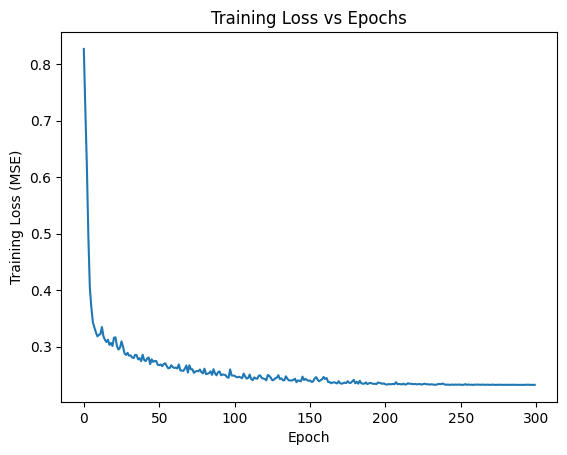

In [251]:
plt.figure()
plt.plot(val_loss_history)
plt.xlabel("Epoch")
plt.ylabel("Training Loss (MSE)")
plt.title("Training Loss vs Epochs")
plt.show()

In [252]:
dsn.eval()
with torch.no_grad():
    y_pred_scaled = dsn(X_test_t) 

y_pred_real = (y_pred_scaled * y_std) + y_mean

y_true_real = (y_test_t * y_std) + y_mean


y_pred = y_pred_real.cpu().numpy() 
y_true = y_true_real.cpu().numpy()

mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MSE Réelle : {mse:.4f}")
print(f"R² Réel    : {r2:.4f}")

MSE Réelle : 0.3112
R² Réel    : 0.7613


In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
energy_efficiency = fetch_ucirepo(id=242) 
  
# data (as pandas dataframes) 
X = energy_efficiency.data.features 
y = energy_efficiency.data.targets 
  
# metadata 
print(energy_efficiency.metadata) 
  
# variable information 
print(energy_efficiency.variables) 


{'uci_id': 242, 'name': 'Energy Efficiency', 'repository_url': 'https://archive.ics.uci.edu/dataset/242/energy+efficiency', 'data_url': 'https://archive.ics.uci.edu/static/public/242/data.csv', 'abstract': 'This study looked into assessing the heating load and cooling load requirements of buildings (that is, energy efficiency) as a function of building parameters.', 'area': 'Computer Science', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 768, 'num_features': 8, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['Y1', 'Y2'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2012, 'last_updated': 'Mon Feb 26 2024', 'dataset_doi': '10.24432/C51307', 'creators': ['Athanasios Tsanas', 'Angeliki Xifara'], 'intro_paper': {'ID': 379, 'type': 'NATIVE', 'title': 'Accurate quantitative estimation of energy performance of residential buildings using statistical machine 

In [164]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y["Y1"],
    test_size=0.2,
    random_state=42,
    shuffle=True
)
X_train_t = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_test_t  = torch.tensor(X_test.to_numpy(),  dtype=torch.float32)

# Avant le training
y_mean = y_train.mean()
y_std = y_train.std()
y_train_scaled = (y_train - y_mean) / y_std
y_test_scaled = (y_test - y_mean) / y_std

y_train_t = torch.tensor(y_train_scaled.to_numpy(), dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test_scaled.to_numpy(), dtype=torch.float32).unsqueeze(1)

print(X_train_t.shape)  # (N_train, d_input)
print(y_train_t.shape)  # (N_train, 1)

batch_size = 256

train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_t, y_test_t)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

torch.Size([614, 8])
torch.Size([614, 1])


In [192]:
mlp = MLPRegressor(
        hidden_layer_sizes=(256,128, 64),
        activation="relu",
        solver="adam",
        alpha=1e-4,
        batch_size=256,
        learning_rate_init=1e-3,
        max_iter=5000,
        early_stopping=True,
        random_state=0
    )

In [193]:
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)
r2 = r2_score(y_test, y_pred)
print("R²:", r2)

def count_params_mlp(model):
    return sum(w.size + b.size for w, b in zip(model.coefs_, model.intercepts_))
print(count_params_mlp(mlp))

MSE: 14.008745652864592
R²: 0.8655997566405411
43521


In [167]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
dsn = dsn.to(device)

In [194]:
d_input = X_train.shape[1]
epochs = 50
learning_rate = 1e-3
n_samples = X.shape[0]
batch_size = 128

dims = [d_input,16,8,8,1]
dsn = DeepSpectralNet(dims, ortho_mode=None,use_layernorm=True)

# 1. Obtenir le nombre total de paramètres
total_params = dsn.num_parameters
print(f"Nombre total de paramètres : {total_params}")

# 2. Vérifier une couche spécifique
layer_params = dsn.layers[0].num_parameters
print(f"Paramètres de la première couche : {layer_params}")

# ==== Optimiseur et loss ====
optimizer = torch.optim.AdamW(dsn.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=100
)
criterion = nn.MSELoss()

Nombre total de paramètres : 913
Paramètres de la première couche : 216


In [190]:
epochs = 1000
train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
    # ======== Training ========
    dsn.train()
    total_train_loss = 0.0

    for Xb, yb in train_loader:
        optimizer.zero_grad()
        y_pred = dsn(Xb)         
        loss = criterion(y_pred, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(dsn.parameters(), max_norm=1.0)
        optimizer.step()

        total_train_loss += loss.item() * Xb.size(0)

    avg_train_loss = total_train_loss / len(train_loader.dataset)
    train_loss_history.append(avg_train_loss)
    scheduler.step(avg_train_loss)

    # ======== Validation ========
    dsn.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for Xb, yb in test_loader:  
            y_pred = dsn(Xb)
            loss = criterion(y_pred, yb)
            total_val_loss += loss.item() * Xb.size(0)

    avg_val_loss = total_val_loss / len(test_loader.dataset)
    val_loss_history.append(avg_val_loss)

    # ======== Logging ========
    if epoch % 20 == 0 or epoch == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {avg_train_loss:.6f} | "
              f"Val Loss: {avg_val_loss:.6f} | LR: {current_lr:.6f}")

Epoch 1/1000 | Train Loss: 0.082720 | Val Loss: 0.099386 | LR: 0.001000
Epoch 21/1000 | Train Loss: 0.025868 | Val Loss: 0.023124 | LR: 0.001000
Epoch 41/1000 | Train Loss: 0.024879 | Val Loss: 0.019192 | LR: 0.001000
Epoch 61/1000 | Train Loss: 0.022790 | Val Loss: 0.020812 | LR: 0.001000
Epoch 81/1000 | Train Loss: 0.024884 | Val Loss: 0.019083 | LR: 0.001000
Epoch 101/1000 | Train Loss: 0.022810 | Val Loss: 0.020353 | LR: 0.001000
Epoch 121/1000 | Train Loss: 0.023237 | Val Loss: 0.017477 | LR: 0.001000
Epoch 141/1000 | Train Loss: 0.024263 | Val Loss: 0.021072 | LR: 0.001000
Epoch 161/1000 | Train Loss: 0.020715 | Val Loss: 0.016184 | LR: 0.001000
Epoch 181/1000 | Train Loss: 0.029602 | Val Loss: 0.024228 | LR: 0.001000
Epoch 201/1000 | Train Loss: 0.023445 | Val Loss: 0.020833 | LR: 0.001000
Epoch 221/1000 | Train Loss: 0.022477 | Val Loss: 0.022390 | LR: 0.001000
Epoch 241/1000 | Train Loss: 0.024456 | Val Loss: 0.018218 | LR: 0.001000
Epoch 261/1000 | Train Loss: 0.021566 | Val 

In [118]:
history = train_model(
    model=dsn,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=500,
)

🚀 Start Training | Device: MPS | Total Epochs: 500


Progression:   0%|          | 0/500 [00:00<?, ?epoch/s]

Epoch 100/500 | Train: 0.9984 | Val: 1.0364
Epoch 200/500 | Train: 0.9984 | Val: 1.0366
Epoch 300/500 | Train: 0.9984 | Val: 1.0363
Epoch 400/500 | Train: 0.9984 | Val: 1.0367


KeyboardInterrupt: 

In [191]:
dsn.eval()
with torch.no_grad():
    y_pred_scaled = dsn(X_test_t) 

y_pred_real = (y_pred_scaled * y_std) + y_mean

y_true_real = (y_test_t * y_std) + y_mean


y_pred = y_pred_real.cpu().numpy() 
y_true = y_true_real.cpu().numpy()

mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MSE Réelle : {mse:.4f}")
print(f"R² Réel    : {r2:.4f}")
total_params = dsn.num_parameters
print(f"Nombre total de paramètres : {total_params}")

MSE Réelle : 0.6379
R² Réel    : 0.9939
Nombre total de paramètres : 913
